In [1]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st

In [2]:
# Data - BHRC
# Reporter - clinician
# Hypothesis - 2b (depressed w/o comorbidities vs not depressed but with adhd/anxiety)

# Loading and prepping BHRC data

In [3]:
path_to_bhrcfile = '/data/MBDU/bhrc/data/Pine_129BHRC_2022_04_14.csv'
bhrcfile = pd.read_csv(path_to_bhrcfile, sep=',', header=0, low_memory=False)
print(bhrcfile.head(10))
print(bhrcfile.shape)

   ident redcap_event_name        age        agem      page1      page1m  \
0      1       wave0_arm_1   7.033539   84.402464        NaN         NaN   
1      1       wave1_arm_1  10.800821  129.609856  10.932238  131.186858   
2      1       wave2_arm_1  15.635866  187.630390  15.808350  189.700205   
3      2       wave0_arm_1   7.058179   84.698152        NaN         NaN   
4      2       wave1_arm_1  10.132786  121.593429  10.784394  129.412731   
5      2       wave2_arm_1  15.430527  185.166324  15.504449  186.053388   
6      3       wave0_arm_1   8.361396  100.336756   8.591376  103.096509   
7      3       wave1_arm_1  11.394935  136.739220  12.090349  145.084189   
8      3       wave2_arm_1  16.301164  195.613963  16.550308  198.603696   
9      4       wave0_arm_1  10.409309  124.911704        NaN         NaN   

       page2      page2m       nage       nagem  ...  np_cl_p_fl  \
0        NaN         NaN        NaN         NaN  ...         NaN   
1  10.932238  131.186858   

https://aseba.org/wp-content/uploads/DSM-Oriented-Guide-for-the-ASEBA.pdf <br>
DSM5 - summarize items  items 5, 14, 18, 24, 35, 52, 54, 76, 77, 91, 100, 102 and 103 <br>

### Table 1-3 a Items Comprising DSM-5-Oriented Scales for Ages 6-18
--> 5. Enjoys little (dom_s08_cbclp_w0w2 - cl5 - Few things give pleasure)<br>
--> 14. Cries (dom_s08_cbclp_w0w2 - cl14 - Cries a lot)<br>
--> 18. Harms self (cl18 - Hurts him/herself on purpose or tried to kill him/herself)<br>
--> 24. Doesn’t eat well (cl24 - Is hard to eat)<br>
--> 35. Worthless (cl35 - Feels worthless or inferior)<br>
--> 52. Guilty (cl52 - Feels very guilty)<br>
--> 54. Tired (cl54 - Feels too tired for no reason)<br>
--> 60. Apathetic - leave it because it's not in CBCL<br>
--> 76. Sleeps less (cl76 - Sleep less than most children)<br>
--> 77. Sleeps more (cl77 - Sleep more than most children during the day and / or at night)<br>
--> 91. Talks/thinks suicide (cl91 - Say you're going to kill yourself)<br>
--> 100. Sleep problems (cl100 - Have sleep problems)<br>
--> 102. Lacks energy  (cl102 - Is poorly active, slow in movement, or lacking energy)<br>
--> 103. Sad (cl103 - Is unhappy, sad or depressed)<br>


In [4]:
relevant_depression_columns = ["cl5", "cl14", "cl18", "cl24", "cl35", "cl52", "cl54", "cl76", "cl77", "cl91", "cl100", "cl102", "cl103"]

In [5]:
# Check if there are no "99"s

for column in relevant_depression_columns:
    print(bhrcfile[column].value_counts())

0.0     3686
1.0     1175
2.0      492
99.0      10
Name: cl5, dtype: int64
0.0    4241
1.0     774
2.0     349
Name: cl14, dtype: int64
0.0    5157
1.0     138
2.0      69
Name: cl18, dtype: int64
0.0     4310
1.0      696
2.0      357
99.0       1
Name: cl24, dtype: int64
0.0     4381
1.0      735
2.0      245
99.0       3
Name: cl35, dtype: int64
0.0     4835
1.0      417
2.0      108
99.0       4
Name: cl52, dtype: int64
0.0     3962
1.0      908
2.0      490
99.0       4
Name: cl54, dtype: int64
0.0     4643
1.0      452
2.0      268
99.0       1
Name: cl76, dtype: int64
0.0     3985
1.0      785
2.0      592
99.0       2
Name: cl77, dtype: int64
0.0     5077
1.0      199
2.0       84
99.0       3
Name: cl91, dtype: int64
0.0     4829
1.0      375
2.0      157
99.0       2
Name: cl100, dtype: int64
0.0     4671
1.0      532
2.0      155
99.0       5
Name: cl102, dtype: int64
0.0     4474
1.0      716
2.0      171
99.0       1
Name: cl103, dtype: int64


In [6]:
# check where nans are
checkdf = bhrcfile[(bhrcfile[relevant_depression_columns] >98).any(axis=1)]
print(checkdf.redcap_event_name.value_counts())
print(checkdf.p1dawbaage.value_counts())

wave2_arm_1    23
wave1_arm_1     4
Name: redcap_event_name, dtype: int64
16.950034    1
16.386037    1
17.911020    1
16.071184    1
16.605065    1
14.056126    1
17.757700    1
13.645448    1
17.620808    1
16.867899    1
16.191650    1
17.938398    1
15.329227    1
16.769336    1
16.038330    1
15.906913    1
14.822724    1
17.806982    1
17.546886    1
17.648186    1
13.409993    1
15.509925    1
17.908282    1
16.900753    1
17.138946    1
17.812457    1
17.010267    1
Name: p1dawbaage, dtype: int64


In [ ]:
# no missing data in our age group. Phew.

In [5]:
# Remove the 99s, replace them with 0

'''for column in relevant_depression_columns:
    bhrcfile[column].values[bhrcfile[column] > 98] = 0
    print(bhrcfile[column].value_counts())'''

0.0    3696
1.0    1175
2.0     492
Name: cl5, dtype: int64
0.0    4241
1.0     774
2.0     349
Name: cl14, dtype: int64
0.0    5157
1.0     138
2.0      69
Name: cl18, dtype: int64
0.0    4311
1.0     696
2.0     357
Name: cl24, dtype: int64
0.0    4384
1.0     735
2.0     245
Name: cl35, dtype: int64
0.0    4839
1.0     417
2.0     108
Name: cl52, dtype: int64
0.0    3966
1.0     908
2.0     490
Name: cl54, dtype: int64
0.0    4644
1.0     452
2.0     268
Name: cl76, dtype: int64
0.0    3987
1.0     785
2.0     592
Name: cl77, dtype: int64
0.0    5080
1.0     199
2.0      84
Name: cl91, dtype: int64
0.0    4831
1.0     375
2.0     157
Name: cl100, dtype: int64
0.0    4676
1.0     532
2.0     155
Name: cl102, dtype: int64
0.0    4475
1.0     716
2.0     171
Name: cl103, dtype: int64


In [6]:
# relevant_depression_columns = ["cl5", "cl14", "cl18", "cl24", "cl35", "cl52", "cl54", "cl76", "cl77", "cl91", "cl100", "cl102", "cl103"]
bhrcfile['cbcl_dsm_depression'] = bhrcfile.cl5 + bhrcfile.cl14 + bhrcfile.cl18 + bhrcfile.cl24 + bhrcfile.cl35 + bhrcfile.cl52 + bhrcfile.cl54 + bhrcfile.cl76 + bhrcfile.cl77 + bhrcfile.cl91 + bhrcfile.cl100 + bhrcfile.cl102 + bhrcfile.cl103
bhrcfile['cbcl_dsm_depression'].value_counts()

0.0     1669
1.0      907
2.0      716
3.0      485
4.0      398
6.0      254
5.0      249
7.0      150
8.0      133
9.0      103
10.0      69
11.0      54
12.0      52
13.0      33
15.0      28
14.0      19
16.0      12
17.0       9
18.0       8
19.0       4
20.0       4
21.0       3
23.0       1
22.0       1
Name: cbcl_dsm_depression, dtype: int64

In [7]:
bhrcfile['depression_clinician'] = (bhrcfile.dcmadep == 2) | (bhrcfile.dcotdep == 2)
bhrcfile['healthy_clinician'] = (bhrcfile.dcany == 0)
bhrcfile['anxiety_clinician'] = (bhrcfile.dcsepa == 2) | \
                        (bhrcfile.dcspph == 2) | \
                        (bhrcfile.dcsoph == 2) | \
                        (bhrcfile.dcpanic == 2) |\
                        (bhrcfile.dcagor == 2) | \
                        (bhrcfile.dcgena == 2) | \
                        (bhrcfile.dcotanx == 2) 
bhrcfile['ADHD_clinician'] = (bhrcfile.dcanyhk == 2)
bhrcfile['depYES_anxietyadhdNO_clinician'] = (bhrcfile.depression_clinician == True) & ((bhrcfile.anxiety_clinician == False) & (bhrcfile.ADHD_clinician == False))
bhrcfile['depNO_anxietyadhdYES_clinician'] = (bhrcfile.depression_clinician == False) & ((bhrcfile.anxiety_clinician == True) | (bhrcfile.ADHD_clinician == True))

bhrcfile['depression_clinician_9to13'] = (bhrcfile.depression_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['healthy_clinician_9to13'] = (bhrcfile.healthy_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['depYES_anxietyadhdNO_clinician_9to13'] = (bhrcfile.depYES_anxietyadhdNO_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
bhrcfile['depNO_anxietyadhdYES_clinician_9to13'] = (bhrcfile.depNO_anxietyadhdYES_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)

example table:<br>
<br>
ident redcap_event_name        age        agem      page1      page1m  \
0      1       wave0_arm_1   7.033539   84.402464        NaN         NaN   
1      1       wave1_arm_1  10.800821  129.609856  10.932238  131.186858   
2      1       wave2_arm_1  15.635866  187.630390  15.808350  189.700205   
3      2       wave0_arm_1   7.058179   84.698152        NaN         NaN   
4      2       wave1_arm_1  10.132786  121.593429  10.784394  129.412731   
5      2       wave2_arm_1  15.430527  185.166324  15.504449  186.053388   
6      3       wave0_arm_1   8.361396  100.336756   8.591376  103.096509   
7      3       wave1_arm_1  11.394935  136.739220  12.090349  145.084189   
8      3       wave2_arm_1  16.301164  195.613963  16.550308  198.603696   
9      4       wave0_arm_1  10.409309  124.911704        NaN         NaN   

In [8]:
#removing all rows where p1dawbaage <9 or >13
bhrcfile = bhrcfile[bhrcfile.p1dawbaage >= 9]
bhrcfile = bhrcfile[bhrcfile.p1dawbaage <= 13]
print(bhrcfile.shape)
print(bhrcfile['p1dawbaage'].value_counts())

(2259, 2261)
10.475017    8
11.271732    7
11.761807    6
11.797399    6
11.164956    6
            ..
12.114990    1
11.455168    1
11.507187    1
12.533881    1
9.505818     1
Name: p1dawbaage, Length: 1128, dtype: int64


In [9]:
bhrcfile.head()

,ident,redcap_event_name,age,agem,page1,page1m,page2,page2m,nage,nagem,...,depression_clinician,healthy_clinician,anxiety_clinician,ADHD_clinician,depYES_anxietyadhdNO_clinician,depNO_anxietyadhdYES_clinician,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13
1,1,wave1_arm_1,10.800821,129.609856,10.932238,131.186858,10.932238,131.186858,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
4,2,wave1_arm_1,10.132786,121.593429,10.784394,129.412731,10.789870,129.478439,NaN,NaN,...,False,False,True,False,False,True,False,False,False,True
7,3,wave1_arm_1,11.394935,136.739220,12.090349,145.084189,12.090349,145.084189,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
9,4,wave0_arm_1,10.409309,124.911704,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False
13,5,wave1_arm_1,10.809035,129.708419,11.438741,137.264887,11.438741,137.264887,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False


In [10]:
bhrcfile.ident.value_counts()

2512    2
1976    2
567     2
2017    2
549     2
       ..
869     1
868     1
867     1
866     1
1296    1
Name: ident, Length: 2083, dtype: int64

In [11]:
# sort by age and subject and then group by subject and use .first()

In [12]:
bhrcfile.redcap_event_name.value_counts()

wave0_arm_1    1551
wave1_arm_1     708
Name: redcap_event_name, dtype: int64

In [13]:
bhrcfile = bhrcfile.replace('wave0_arm_1', 0)
bhrcfile = bhrcfile.replace('wave1_arm_1', 1)
bhrcfile = bhrcfile.replace('wave2_arm_1', 2)
bhrcfile.redcap_event_name.value_counts()

0    1551
1     708
Name: redcap_event_name, dtype: int64

In [14]:
bhrcfile = bhrcfile.sort_values(['ident', 'p1dawbaage'])
bhrcfile = bhrcfile.groupby(by=['ident'])
bhrcfile[['ident', 'redcap_event_name', 'p1dawbaage']].head(10)

,ident,redcap_event_name,p1dawbaage
1,1,1,10.937714
4,2,1,10.800821
7,3,1,12.054757
9,4,0,10.475017
13,5,1,11.173169
...,...,...,...
7521,2509,0,9.505818
7522,2509,1,12.703628
7528,2511,1,12.002738
7530,2512,0,9.297741


In [15]:
bhrcfile.ident.value_counts()

ident  ident
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
               ..
2507   2507     1
2508   2508     1
2509   2509     2
2511   2511     1
2512   2512     2
Name: ident, Length: 2083, dtype: int64

In [16]:
bhrcfile = bhrcfile.first('1D')
bhrcfile[['redcap_event_name', 'p1dawbaage']].head()

,redcap_event_name,p1dawbaage
ident,,
1,1,10.937714
2,1,10.800821
3,1,12.054757
4,0,10.475017
5,1,11.173169


In [17]:
bhrcfile = bhrcfile.reset_index(level=0)
bhrcfile.ident.value_counts()

1       1
1706    1
1703    1
1701    1
1700    1
       ..
853     1
850     1
849     1
848     1
2512    1
Name: ident, Length: 2083, dtype: int64

In [18]:
# checking numbers of depressed etc
print("Depressed 9 to 13 - clinician")
print(bhrcfile['depression_clinician_9to13'].value_counts())
print("\nHealthy 9 to 13 - clinician")
print(bhrcfile['healthy_clinician_9to13'].value_counts())
print("\ndepYES_anxietyadhdNO_clinician - clinician")
print(bhrcfile['depYES_anxietyadhdNO_clinician_9to13'].value_counts())
print("\ndepNO_anxietyadhdYES_clinician - clinician")
print(bhrcfile['depNO_anxietyadhdYES_clinician_9to13'].value_counts())

Depressed 9 to 13 - clinician
False    2003
True       80
Name: depression_clinician_9to13, dtype: int64

Healthy 9 to 13 - clinician
True     1543
False     540
Name: healthy_clinician_9to13, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
False    2040
True       43
Name: depYES_anxietyadhdNO_clinician_9to13, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
False    1723
True      360
Name: depNO_anxietyadhdYES_clinician_9to13, dtype: int64


In [19]:
bhrcfile.shape

(2083, 2152)

In [20]:
mybhrcfile = bhrcfile[['ident', 'p1dawbaage', 'redcap_event_name', 'depression_clinician_9to13', 'healthy_clinician_9to13', 'depYES_anxietyadhdNO_clinician_9to13', 'depNO_anxietyadhdYES_clinician_9to13', 'cbcl_dsm_depression']]
print(mybhrcfile.shape)
print(mybhrcfile.head())

(2083, 8)
   ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
0      1   10.937714                  1                       False   
1      2   10.800821                  1                       False   
2      3   12.054757                  1                       False   
3      4   10.475017                  0                       False   
4      5   11.173169                  1                       False   

   healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
0                     True                                 False   
1                    False                                 False   
2                     True                                 False   
3                     True                                 False   
4                     True                                 False   

   depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  
0                                 False                  0.0  
1                           

In [21]:
mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)
mybhrcfile.head(10)

/tmp/ipykernel_13017/2129885117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


,ident,p1dawbaage,redcap_event_name,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13,cbcl_dsm_depression,gs_depression
0,1,10.937714,1,False,True,False,False,0.0,0
1,2,10.800821,1,False,False,False,True,5.0,0
2,3,12.054757,1,False,True,False,False,1.0,0
3,4,10.475017,0,False,True,False,False,1.0,0
4,5,11.173169,1,False,True,False,False,1.0,0
5,6,10.795346,0,True,False,True,False,13.0,1
6,7,9.229295,0,False,True,False,False,0.0,0
7,9,12.394251,0,False,True,False,False,0.0,0
8,10,12.265572,1,False,True,False,False,3.0,0
9,11,10.154689,0,False,True,False,False,0.0,0


# HYPOTHESIS DIFFERENCES BEGIN HERE

We prepare a dataset to work with, of desir4ed length and positive/negative case ratio

## Split into negative and positive gs diagnoses

In [22]:
is_gs_pos =  mybhrcfile['depYES_anxietyadhdNO_clinician_9to13']==1
pos_gs_all = mybhrcfile[is_gs_pos]
print(pos_gs_all.shape)

(43, 9)


In [23]:
pos_gs_all.head()

,ident,p1dawbaage,redcap_event_name,depression_clinician_9to13,healthy_clinician_9to13,depYES_anxietyadhdNO_clinician_9to13,depNO_anxietyadhdYES_clinician_9to13,cbcl_dsm_depression,gs_depression
5,6,10.795346,0,True,False,True,False,13.0,1
13,15,12.416153,0,True,False,True,False,4.0,1
94,108,10.746064,0,True,False,True,False,11.0,1
127,145,11.236140,0,True,False,True,False,11.0,1
134,157,12.490075,0,True,False,True,False,8.0,1


In [24]:
is_gs_neg =  mybhrcfile['depNO_anxietyadhdYES_clinician_9to13']==True
neg_gs_all = mybhrcfile[is_gs_neg]
print(neg_gs_all.shape)

(360, 9)


## Randomly choose the neg_ksads subsample

In [25]:
num_pos = pos_gs_all.shape[0]
size_subsample = 360 # !
print(size_subsample)
neg_gs_subsample = neg_gs_all.sample(n = size_subsample)
print(neg_gs_subsample.head())
neg_gs_subsample.shape

360
      ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
737     914   12.421629                  0                       False   
638     793   10.094456                  0                       False   
652     807   10.590007                  0                       False   
1726   2093    9.648186                  0                       False   
1882   2283   10.992471                  0                       False   

      healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
737                     False                                 False   
638                     False                                 False   
652                     False                                 False   
1726                    False                                 False   
1882                    False                                 False   

      depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  gs_depression  
737                                   True 

(360, 9)

## Mix all positive cases and the subsample of negative cases. Then shuffle. 

In [26]:
frames = [pos_gs_all, neg_gs_subsample]
my_subsample = pd.concat(frames)
print(my_subsample.head())
print(my_subsample.shape)
my_subsample = my_subsample.sample(frac = 1)
print(my_subsample.head())
print(my_subsample.shape)

     ident  p1dawbaage  redcap_event_name  depression_clinician_9to13  \
5        6   10.795346                  0                        True   
13      15   12.416153                  0                        True   
94     108   10.746064                  0                        True   
127    145   11.236140                  0                        True   
134    157   12.490075                  0                        True   

     healthy_clinician_9to13  depYES_anxietyadhdNO_clinician_9to13  \
5                      False                                  True   
13                     False                                  True   
94                     False                                  True   
127                    False                                  True   
134                    False                                  True   

     depNO_anxietyadhdYES_clinician_9to13  cbcl_dsm_depression  gs_depression  
5                                   False                 13

In [27]:
my_subsample.isnull().sum()

ident                                   0
p1dawbaage                              0
redcap_event_name                       0
depression_clinician_9to13              0
healthy_clinician_9to13                 0
depYES_anxietyadhdNO_clinician_9to13    0
depNO_anxietyadhdYES_clinician_9to13    0
cbcl_dsm_depression                     0
gs_depression                           0
dtype: int64

# AUCROC
## Heavily using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [28]:
y_true_df = my_subsample['gs_depression']
y_cbcl_df = my_subsample['cbcl_dsm_depression']

y_true = my_subsample['gs_depression'].tolist() # called y_test in the example
y_cbcl = my_subsample['cbcl_dsm_depression'].tolist() # called y_score in the example

In [29]:
sample_auc_score = roc_auc_score(y_true, y_cbcl)
sample_auc_score
# Note that we don't report this number in the paper. 
# Instead, we run bootstrapping and report bootstrap AUCROC, with confidence intervals.

0.7808462532299743

In [30]:
# plotting

In [31]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_true_df, y_cbcl_df)
roc_auc = auc(fpr, tpr)
roc_auc

0.7808462532299743

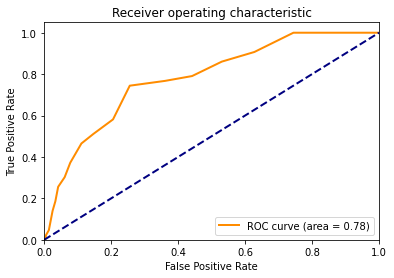

In [32]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# SAVING

In [ ]:
# We save these data to make figures for the paper later

In [33]:
with open('../data_for_plotting/BHRC_data/BHRC_Hyp2b_y_true_df.npy', 'wb') as f:
    np.save(f, y_true_df)
with open('../data_for_plotting/BHRC_data/BHRC_Hyp2b_y_cbcl_df.npy', 'wb') as f:
    np.save(f, y_cbcl_df)

In [34]:
with open('../data_for_plotting/BHRC_data/BHRC_Hyp2b_y_true_df.npy', 'rb') as f:
    my_true_df = np.load(f)
with open('../data_for_plotting/BHRC_data/BHRC_Hyp2b_y_cbcl_df.npy', 'rb') as f:
    my_cbcl_df = np.load(f)

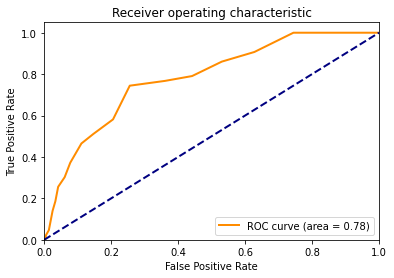

In [35]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Bootstrapping

In [36]:
rng = np.random.default_rng()
boot_ind = rng.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
boot_ind

array([354, 286, 292, 149, 375, 376,  99, 140, 107, 250,  57, 171, 382,
       249, 339, 337, 313, 101, 103, 302, 277, 134, 346, 272,  64, 224,
       185, 387, 347, 355,  91, 268, 180, 190, 349,  81,  78, 339, 286,
       118, 359,  90,   4, 229, 264,  51, 324,  31, 325,  27,  65, 138,
       390, 244, 264,  57,  95, 329, 247,  74, 389, 147, 261, 212, 328,
        85,  64,  66, 288, 179, 331, 196, 322,  13, 278, 288, 159, 353,
       164, 121,   0, 333, 181, 166, 216, 388, 234, 289, 396,  97, 219,
       309, 150, 245, 307, 245, 130, 371, 345, 243,  90, 102,  90, 313,
        16,  98, 243, 114, 202, 156,  70, 254,  68, 210, 241, 250, 158,
       400, 273, 294, 289, 132, 270, 328, 323, 283, 284,  26, 265,  70,
       155, 240, 201, 346,  56, 374, 201,  86,  11,  14, 312, 179, 391,
       378, 254, 236,  63, 202, 391, 249, 142, 213, 211, 171,   2,  63,
       207, 264, 213, 178, 281, 114,  69,  89, 354, 345, 155, 216,  76,
       307, 272, 322, 202, 366,  38, 338, 167,  56,  63, 180, 25

In [37]:
print(type(y_true_df))
y_true_df = y_true_df.to_frame()
y_cbcl_df = y_cbcl_df.to_frame()
print(type(y_true_df))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [38]:
y_true_df.head()

,gs_depression
757,1
949,0
845,0
988,0
1824,0


In [39]:
boot_truth = y_true_df.iloc[boot_ind]
boot_score = y_cbcl_df.iloc[boot_ind]
print(y_cbcl_df.head(5))
print(boot_score.head(5))

      cbcl_dsm_depression
757                   2.0
949                   1.0
845                   2.0
988                   6.0
1824                  5.0
      cbcl_dsm_depression
930                   2.0
905                  16.0
186                   8.0
1311                 10.0
42                    0.0


In [40]:
def gen_auc_boots(scores, truth, nboots=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth.iloc[boot_ind]
        boot_score = scores.iloc[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

In [41]:
target_auc = 0.75 # because we defined it this way. Change for Hyp 2b.

boots = gen_auc_boots(y_cbcl_df, y_true_df, nboots=1000, rng=rng)
boots = np.hstack([boots, np.array([sample_auc_score])])
p = (boots >= target_auc).mean()

In [42]:
boots

array([0.84129497, 0.78812946, 0.76732883, ..., 0.7359944 , 0.73376303,
       0.78084625])

In [43]:
min(boots)

0.6620835326000318

In [44]:
p

0.8031968031968032

In [45]:
target_auc

0.75

# RESULTS

In [46]:
p_onesided = (boots >= target_auc).mean()
p_onesided

0.8031968031968032

In [48]:
p_twosided1 = (boots > target_auc).mean()
p_twosided2 = (boots < target_auc).mean()
p_twosided = min(p_twosided1, p_twosided2)*2
p_twosided

0.3936063936063936

In [52]:
print(np.quantile(boots, .025))
print(np.quantile(boots, .975))
boots_mean_AUCROC = np.mean(boots)
print(boots_mean_AUCROC, '(', np.quantile(boots, .025), np.quantile(boots, .975), ')')

(0.7790761642173175, 0.783555522730159)

# Confusion matrix

In [53]:
conf_fpr, conf_tpr, conf_thresh = roc_curve(y_true, y_cbcl)
conf_thresh

array([21., 20., 18., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,
        6.,  5.,  4.,  3.,  2.,  0.])

In [54]:
roc_auc = auc(conf_fpr, conf_tpr)
roc_auc

0.7808462532299743

In [55]:
print(y_cbcl[:50])
print(min(y_cbcl))
print(max(y_cbcl))

[2.0, 1.0, 2.0, 6.0, 5.0, 15.0, 4.0, 2.0, 6.0, 2.0, 3.0, 8.0, 0.0, 7.0, 9.0, 11.0, 7.0, 7.0, 0.0, 5.0, 3.0, 0.0, 15.0, 0.0, 6.0, 0.0, 3.0, 0.0, 6.0, 8.0, 3.0, 1.0, 5.0, 4.0, 4.0, 2.0, 4.0, 2.0, 10.0, 6.0, 5.0, 0.0, 16.0, 12.0, 0.0, 5.0, 4.0, 2.0, 0.0, 1.0]
0.0
20.0


In [56]:
def predict_y(cbcl, threshold):
    y_score = []
    for item in y_cbcl:
        if item >= threshold:
            y_score.append(1)
        else:
            y_score.append(0)
    return y_score

In [57]:
# Create a dataframe for all data for thresholds and associated fpr, tpr, tp, tn, fp, fn

# and also euclidian distance
# --> tpr - y axis 
# --> fpr - x axis 
# We want to calculate an Euclidian distance to (0,1) for each point on the ROC curve and pick the point where that is minimized. 

## dist = sqrt((x2 - x1)^2 + (y2 - y1)^2) 
## dist = sqrt(square(x2 - x1) + square(y2 - y1)) 

# I will create the df from a list of lists

# first initiate the lists

all_roc_auc = []
all_fpr = []
all_tpr = []
all_tn = []
all_fp = []
all_fn = []
all_tp = []
all_thresholds = []
all_euclidian = []

# Point to calculate the Euclidian distance with - (0, 1)
optimal_performance = np.array((0, 1))

# now iterate through thesholds, calculate the values of interest, update the lists

for threshold in range (0,50): #51,90
    # predict diagnoses with the given threshold
    y_score = predict_y(y_cbcl, threshold)
    # calculate fp, fn, tp, tn, aucroc
    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    # calculate euclidian
    fpr_tpr_datapoint = np.array((fpr, tpr))
    sum_sq = np.sum(np.square(optimal_performance - fpr_tpr_datapoint))
    euclidian = np.sqrt(sum_sq)
    
    # update all lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_tn.append(tn)
    all_fp.append(fp)
    all_fn.append(fn)
    all_tp.append(tp)
    all_thresholds.append(threshold)
    all_euclidian.append(euclidian)


# make a dataframe out of lists

conf_matrices_data = pd.DataFrame(list(zip(all_thresholds, all_euclidian, all_fpr, all_tpr, all_tp, all_tn, all_fp, all_fn)),
               columns =['threshold', 'Euclidian', 'FPR', 'TPR', 'TP', 'TN', 'FP', 'FN'])

conf_matrices_data

,threshold,Euclidian,FPR,TPR,TP,TN,FP,FN
0,0,1.000000,1.000000,1.000000,43,0,360,0
1,1,0.872222,0.872222,1.000000,43,46,314,0
2,2,0.744444,0.744444,1.000000,43,92,268,0
3,3,0.634632,0.627778,0.906977,39,134,226,4
4,4,0.548597,0.530556,0.860465,37,169,191,6
5,5,0.488750,0.441667,0.790698,34,201,159,9
6,6,0.429517,0.361111,0.767442,33,230,130,10
7,7,0.361593,0.255556,0.744186,32,268,92,11
8,8,0.466351,0.205556,0.581395,25,286,74,18
9,9,0.510080,0.147222,0.511628,22,307,53,21


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


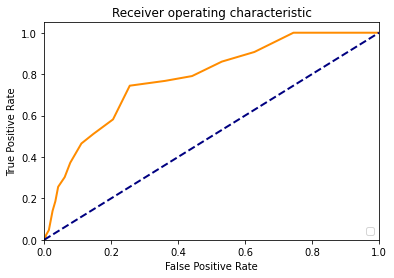

In [58]:
# Just to visualize

plt.figure()
lw = 2 # linewidt
plt.plot(
    all_fpr,
    all_tpr,
    color="darkorange",
    lw=lw,
    #label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [59]:
# Find the best fpr/tpr pair

# What is the min euclidian distance in the dataframe?
conf_matrices_data[['Euclidian']].idxmin()

Euclidian    7
dtype: int64

In [60]:
conf_matrices_data.loc[7]

threshold      7.000000
Euclidian      0.361593
FPR            0.255556
TPR            0.744186
TP            32.000000
TN           268.000000
FP            92.000000
FN            11.000000
Name: 7, dtype: float64